In [1]:
from statistics import mean
import pandas as pd
import numpy as np
import pandas_profiling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_score, recall_score, make_scorer, accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

In [2]:
heart_disease_data = pd.read_csv("./heart.csv")

In [3]:
heart_disease_data.HeartDisease.value_counts(normalize=True)*100
heart_disease_data['Cholesterol'] = heart_disease_data['Cholesterol'].replace(0,heart_disease_data['Cholesterol'].std())
heart_disease_data.profile_report()

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


In [4]:
from sklearn.pipeline import Pipeline
%matplotlib inline
from matplotlib import pyplot
def standarize_numerical_features(num_data, max_allowed_skew = 0.5):
  'This function is used to normalize the numerical features which are skewed by applyng log transformation and the other numerical features are standarized.'
  print("The skewness before applying transformation are \n {}".format(num_data.skew()))
  num_data.hist()
  pyplot.show()
  skew_values = num_data.skew()
  skew_cols = (skew_values.sort_values(ascending = False).to_frame().rename(columns = {0:'Skew_data'}).query('abs(Skew_data) > {}'.format(max_allowed_skew)))
  for col in skew_cols.index.values:
    num_data[col] = num_data[col].apply(np.log)
  num_data.fillna(num_data.mean(), inplace = True)
  num_data = num_data.replace([np.inf, -np.inf], 0)
  non_skew_cols = [x for x in num_data.columns.values if x not in skew_cols.index.values]
  scaler = StandardScaler()
  num_data[non_skew_cols] = scaler.fit_transform(num_data[non_skew_cols])
  return num_data

In [5]:
from sklearn.compose import ColumnTransformer
def encode_features(heart_disease_features, categorical_features, numerical_features):
    col = ColumnTransformer( transformers=[('onehotencoder', OneHotEncoder(handle_unknown='ignore'), categorical_features)], remainder='passthrough')
    tr = col.fit_transform(heart_disease_features)
    cat_features = col.named_transformers_['onehotencoder'].get_feature_names_out()
    all_features = np.append(cat_features, numerical_features)
    return pd.DataFrame(tr, columns= all_features)

In [6]:
def process_features(heart_disease_features, numerical_features, categorical_features):
    'This function mainly performs feature engineering.'
    numerical_cols = heart_disease_features[numerical_features].apply(pd.to_numeric, errors= ('coerce'))
    transformed_num_features = standarize_numerical_features(numerical_cols)
    heart_disease_features.update(transformed_num_features)
    return encode_features(heart_disease_features, categorical_features, numerical_features)

The skewness before applying transformation are 
 Age           -0.195933
RestingBP      0.179839
Cholesterol    0.445960
FastingBS      1.264484
MaxHR         -0.144359
Oldpeak        1.022872
dtype: float64


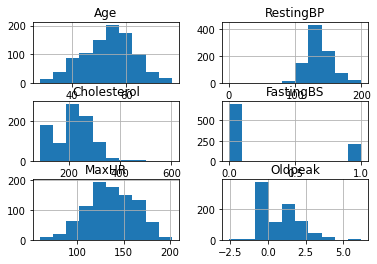

The skewness of the numerical features after power transformation are 
 Age           -0.195933
RestingBP      0.179839
Cholesterol    0.445960
FastingBS      0.000000
MaxHR         -0.144359
Oldpeak       -1.114902
dtype: float64
Data distribution of the numerical features after power transformation


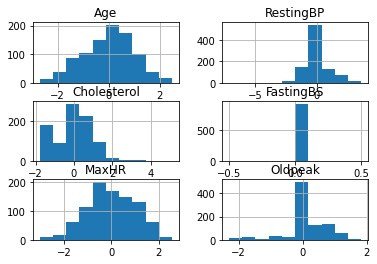

In [7]:
from matplotlib import pyplot
%matplotlib inline
heart_disease_features = heart_disease_data.drop("HeartDisease", axis=1)
heart_disease_target_feature = heart_disease_data['HeartDisease']
numerical_columns = heart_disease_features.select_dtypes(include=np.number).columns.tolist()
categorical_columns = heart_disease_features.select_dtypes(include=['object']).columns.tolist()
transformed_data = process_features(heart_disease_features, numerical_columns, categorical_columns)
print("The skewness of the numerical features after power transformation are \n {}".format(transformed_data[numerical_columns].skew()))
print("Data distribution of the numerical features after power transformation")
transformed_data[numerical_columns].hist()
pyplot.show()

In [8]:
from sklearn.model_selection import train_test_split
'Split the data into training and testing with a 70:30 ratio'

X_train, X_test, Y_train, Y_test = train_test_split(transformed_data, heart_disease_target_feature, test_size = 0.2, random_state = 100)
print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape,"Y_train shape:", Y_train.shape,"y_test shape:", Y_test.shape)
scores_dict = {}
classification_metrics_dict = {}

X_train shape: (734, 20) X_test shape: (184, 20) Y_train shape: (734,) y_test shape: (184,)


In [9]:
kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state = 100)

In [10]:
rf_classifier = RandomForestClassifier(random_state=0)
rf_params = {'n_estimators': [10, 30, 50, 80, 100, 150],
             'max_features': ['auto', 'sqrt', 'log2'],
             'criterion': ['gini', 'entropy'],
             'max_depth': [4, 6, 8, 9, 10]
            }
grid_rf = GridSearchCV(rf_classifier, rf_params, cv = kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid_rf.fit(X_train, Y_train)

print("The best parameters for randomforest classifer is {}".format(grid_rf.best_params_))
print("The best score for randomforest classifer is {}".format(grid_rf.best_score_))

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
The best parameters for randomforest classifer is {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 50}
The best score for randomforest classifer is 0.873306182895224


The accuracy of the model 0.875
              precision    recall  f1-score   support

           0       0.87      0.84      0.85        79
           1       0.88      0.90      0.89       105

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184

The precision of the classifier is 0.8796296296296297
The recall of the classifier is 0.9047619047619048
The F1_score of the classifier is 0.892018779342723


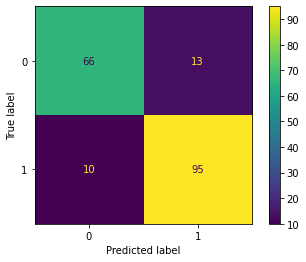

In [11]:
Y_pred = grid_rf.predict(X_test)

accuracy = grid_rf.score(X_test, Y_test)
precision = precision_score(Y_test, Y_pred, average='binary')
recall = recall_score(Y_test, Y_pred, average='binary')
f1 = f1_score(Y_test, Y_pred, average='binary')
print('The accuracy of the model', accuracy)
print(classification_report(Y_test, Y_pred))
print("The precision of the classifier is {}".format(precision))
print("The recall of the classifier is {}".format(recall))
print("The F1_score of the classifier is {}".format(f1))
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)

scores_dict['RandomForest'] = grid_rf.predict_proba(X_test)[:,1]
classification_metrics_dict['RandomForest'] = [round(accuracy,5), round(precision,5), round(recall,5), round(f1,5)]

In [12]:
adaboost_classifier = AdaBoostClassifier(random_state=0)
adaboost_params = {'n_estimators': [10, 30, 50, 80, 100],
                   'learning_rate': [0.2, 0.4, 0.6, 0.8, 1.0, 1.5]
                  }
grid_adaboost = GridSearchCV(adaboost_classifier, adaboost_params, cv = kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid_adaboost.fit(X_train, Y_train)

print("The best parameters for adaboost classifer is {}".format(grid_adaboost.best_params_))
print("The best score for adaboost classifer is {}".format(grid_adaboost.best_score_))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
The best parameters for adaboost classifer is {'learning_rate': 0.2, 'n_estimators': 100}
The best score for adaboost classifer is 0.8692336171788227


The accuracy of the model 0.8586956521739131
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        79
           1       0.88      0.88      0.88       105

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

The precision of the classifier is 0.8761904761904762
The recall of the classifier is 0.8761904761904762
The F1_score of the classifier is 0.8761904761904762


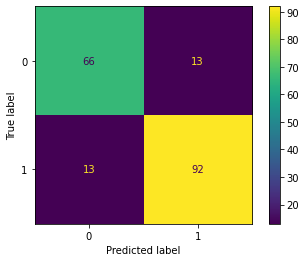

In [13]:

Y_pred = grid_adaboost.predict(X_test)

accuracy = grid_adaboost.score(X_test, Y_test)
precision = precision_score(Y_test, Y_pred, average='binary')
recall = recall_score(Y_test, Y_pred, average='binary')
f1 = f1_score(Y_test, Y_pred, average='binary')
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)

print('The accuracy of the model', accuracy)
print(classification_report(Y_test, Y_pred))
print("The precision of the classifier is {}".format(precision))
print("The recall of the classifier is {}".format(recall))
print("The F1_score of the classifier is {}".format(f1))

classification_metrics_dict['Adaboost'] = [round(accuracy,5), round(precision,5), round(recall,5), round(f1,5)]
scores_dict['Adaboost'] = grid_adaboost.predict_proba(X_test)[:,1]

In [14]:
gb_classifier = GradientBoostingClassifier(random_state=0)
gb_params = {'n_estimators': [10, 30, 50, 80, 100],
             'learning_rate': [0.01, 0.03, 0.05, 0.08, 0.1, 0.2],
             'criterion': ['friedman_mse', 'squared_error']
            }
grid_gb = GridSearchCV(gb_classifier, gb_params, cv = kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid_gb.fit(X_train, Y_train)

print("The best parameters for gradient boosting classifer is {}".format(grid_gb.best_params_))
print("The best score for gradient boosting classifer is {}".format(grid_gb.best_score_))

Fitting 10 folds for each of 60 candidates, totalling 600 fits
The best parameters for gradient boosting classifer is {'criterion': 'friedman_mse', 'learning_rate': 0.05, 'n_estimators': 100}
The best score for gradient boosting classifer is 0.8597186227323214


The accuracy of the model 0.875
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        79
           1       0.89      0.90      0.89       105

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184

The precision of the classifier is 0.8867924528301887
The recall of the classifier is 0.8952380952380953
The F1_score of the classifier is 0.8909952606635072


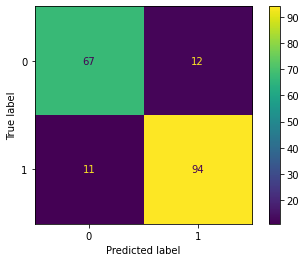

In [15]:
Y_pred = grid_gb.predict(X_test)

accuracy = grid_gb.score(X_test, Y_test)
precision = precision_score(Y_test, Y_pred, average='binary')
recall = recall_score(Y_test, Y_pred, average='binary')
f1 = f1_score(Y_test, Y_pred, average='binary')
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)

print('The accuracy of the model', accuracy)
print(classification_report(Y_test, Y_pred))
print("The precision of the classifier is {}".format(precision))
print("The recall of the classifier is {}".format(recall))
print("The F1_score of the classifier is {}".format(f1))

classification_metrics_dict['GradientBoosting'] = [round(accuracy,5), round(precision,5), round(recall,5), round(f1,5)]
scores_dict['GradientBoosting'] = grid_gb.predict_proba(X_test)[:,1]

In [16]:
et_classifier = ExtraTreesClassifier(random_state=0)
et_params = {'n_estimators': [10, 30, 50, 80, 100, 150],
             'criterion': ['gini', 'entropy'],
             'max_depth': [4, 6, 7, 8, 9, 10]
            }
grid_et = GridSearchCV(et_classifier, et_params, cv = kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid_et.fit(X_train, Y_train)

print("The best parameters for extra trees classifer is {}".format(grid_et.best_params_))
print("The best score for extra trees classifer is {}".format(grid_et.best_score_))

Fitting 10 folds for each of 72 candidates, totalling 720 fits
The best parameters for extra trees classifer is {'criterion': 'entropy', 'max_depth': 7, 'n_estimators': 10}
The best score for extra trees classifer is 0.870584968530174


The accuracy of the model 0.8532608695652174
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        79
           1       0.88      0.86      0.87       105

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184

The precision of the classifier is 0.8823529411764706
The recall of the classifier is 0.8571428571428571
The F1_Score of the classifier is 0.8695652173913043


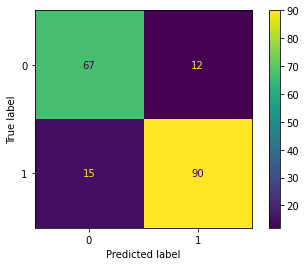

In [17]:
Y_pred = grid_et.predict(X_test)

accuracy = grid_et.score(X_test, Y_test)
precision = precision_score(Y_test, Y_pred, average='binary')
recall = recall_score(Y_test, Y_pred, average='binary')
f1 = f1_score(Y_test, Y_pred, average='binary')
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)

print('The accuracy of the model', accuracy)
print(classification_report(Y_test, Y_pred))

print("The precision of the classifier is {}".format(precision))
print("The recall of the classifier is {}".format(recall))
print("The F1_Score of the classifier is {}".format(f1))
classification_metrics_dict['ExtraTrees'] = [round(accuracy,5), round(precision,5), round(recall,5), round(f1,5)]
scores_dict['ExtraTrees'] = grid_et.predict_proba(X_test)[:,1]

In [18]:
xgb_classifier = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
xgb_params = { 'n_estimators' : [100, 200, 300],
             'max_depth' : [6, 7, 8]
             }
grid_xgb = GridSearchCV(xgb_classifier, xgb_params, cv = StratifiedKFold(n_splits = 2, random_state=999, shuffle=True), scoring = 'accuracy', n_jobs = 4, verbose = 1)
grid_xgb.fit(X_train, Y_train)

print("The best parameters for gradient boosting classifer is {}".format(grid_xgb.best_params_))
print("The best score for gradient boosting classifer is {}".format(grid_xgb.best_score_))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
The best parameters for gradient boosting classifer is {'max_depth': 8, 'n_estimators': 300}
The best score for gradient boosting classifer is 0.8555858310626703


The accuracy of the model 0.8641304347826086
              precision    recall  f1-score   support

           0       0.85      0.84      0.84        79
           1       0.88      0.89      0.88       105

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

The precision of the classifier is 0.8773584905660378
The recall of the classifier is 0.8857142857142857


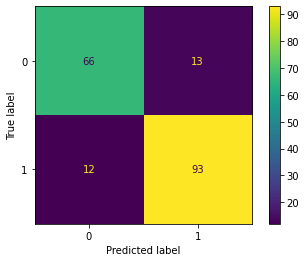

In [19]:
Y_pred = grid_xgb.predict(X_test)

accuracy = grid_xgb.score(X_test, Y_test)
precision = precision_score(Y_test, Y_pred, average='binary')
recall = recall_score(Y_test, Y_pred, average='binary')
f1 = f1_score(Y_test, Y_pred, average='binary')
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)

print('The accuracy of the model', accuracy)
print(classification_report(Y_test, Y_pred))

print("The precision of the classifier is {}".format(precision))
print("The recall of the classifier is {}".format(recall))
classification_metrics_dict['Xgboost'] = [round(accuracy,5), round(precision,5), round(recall,5), round(f1,5)]
scores_dict['Xgboost'] = grid_xgb.predict_proba(X_test)[:,1]

In [20]:
classifiers = [('randomForest', grid_rf.best_estimator_), ('gradientBoosting', grid_gb.best_estimator_), 
('extraTrees', grid_et.best_estimator_), ('adaBoost', grid_adaboost.best_estimator_)]
voting_classifier = VotingClassifier(estimators=classifiers, voting='soft')
voting_params = {'randomForest__n_estimators': [10, 50, 100],
             'extraTrees__n_estimators': [10, 50, 100],
             'adaBoost__n_estimators': [10, 50, 100],
             'gradientBoosting__n_estimators': [10, 50, 100],
            }
grid_voting = GridSearchCV(voting_classifier, voting_params, cv = kfold, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid_voting.fit(X_train, Y_train)

print("The best parameters for extra trees classifer is {}".format(grid_voting.best_params_))
print("The best score for extra trees classifer is {}".format(grid_voting.best_score_))

Fitting 10 folds for each of 81 candidates, totalling 810 fits
The best parameters for extra trees classifer is {'adaBoost__n_estimators': 100, 'extraTrees__n_estimators': 100, 'gradientBoosting__n_estimators': 10, 'randomForest__n_estimators': 10}
The best score for extra trees classifer is 0.8869492780451683


The accuracy of the model 0.8641304347826086
              precision    recall  f1-score   support

           0       0.86      0.81      0.84        79
           1       0.86      0.90      0.88       105

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184

The precision of the classifier is 0.8636363636363636
The recall of the classifier is 0.9047619047619048
The f1 score of the classifier is 0.8837209302325582


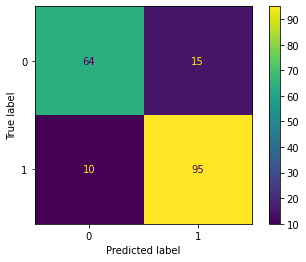

In [21]:
Y_pred = grid_voting.predict(X_test)

accuracy = grid_voting.score(X_test, Y_test)
precision = precision_score(Y_test, Y_pred, average='binary')
recall = recall_score(Y_test, Y_pred, average='binary')
f1 = f1_score(Y_test, Y_pred, average='binary')
print('The accuracy of the model', accuracy)
ConfusionMatrixDisplay.from_predictions(Y_test, Y_pred)

print(classification_report(Y_test, Y_pred))

print("The precision of the classifier is {}".format(precision))
print("The recall of the classifier is {}".format(recall))
print("The f1 score of the classifier is {}".format(f1))
classification_metrics_dict['Voting'] = [round(accuracy,5), round(precision,5), round(recall,5), round(f1,5)]
scores_dict['Voting'] = grid_voting.predict_proba(X_test)[:,1]

In [22]:
def plot_roc(fpr,tpr, label):
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr, label=label)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic example")
  plt.legend(bbox_to_anchor = (1.05, 0.6), loc='best')

def plot_classification_metrics(metrics, metric_names):
    df = pd.DataFrame(metrics, index = metric_names)
    ax = df.plot(kind='barh', rot=0, xlabel='classification metrics', ylabel='Score', title='Metrics', figsize=(10, 10))
    ax.margins(x = 0.1, y = 5)
    ax.legend(title='Columns', bbox_to_anchor=(1, 1.02), loc='upper left')
    for p in ax.patches:
      ax.annotate(str(p.get_width()), (p.get_x() + p.get_width(), p.get_y()), xytext=(2, 2), textcoords='offset points')

    

The AUC score of the model RandomForest is 0.9261000602772755
The AUC score of the model Adaboost is 0.9172393007836046
The AUC score of the model GradientBoosting is 0.9112718505123568
The AUC score of the model ExtraTrees is 0.8970464135021098
The AUC score of the model Xgboost is 0.9053646775165762
The AUC score of the model Voting is 0.918625678119349


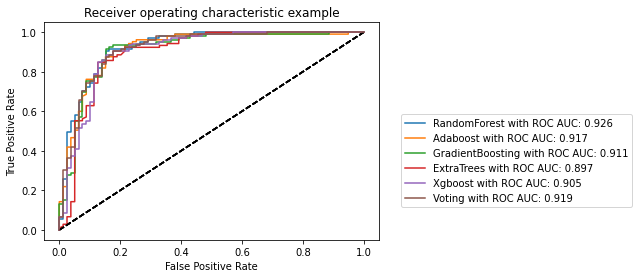

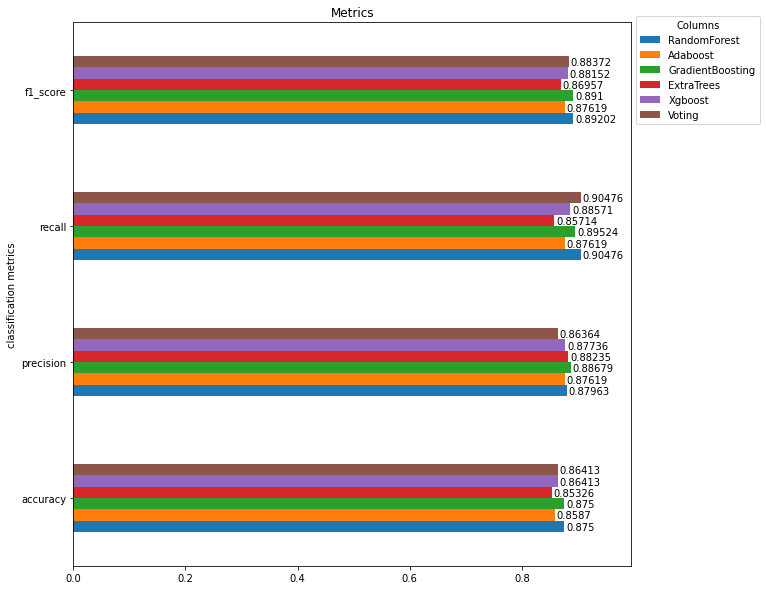

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

fpr_dict = {}
tpr_dict = {}
for classifier in scores_dict:
    print("The AUC score of the model {} is {}".format(classifier, roc_auc_score(Y_test, scores_dict[classifier])))
    fpr_dict[classifier], tpr_dict[classifier], thresholds = roc_curve(Y_test.values, scores_dict[classifier])
for classifier in scores_dict:
    plot_roc(fpr_dict[classifier], tpr_dict[classifier], label = classifier + ' with ROC AUC: ' + str(round(roc_auc_score(Y_test, scores_dict[classifier]),3)))
plt.show()
classification_metrics_names = ['accuracy', 'precision', 'recall', 'f1_score']
plot_classification_metrics(classification_metrics_dict, classification_metrics_names)